<a href="https://colab.research.google.com/github/iwa103/chronos/blob/main/chronos_step_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please understand that there are some risks involved with the installation process.

インストールプロセスで一部動作不安定なのでそのリスクを理解した上で使ってください

0.準備：ライブラリのインストール

Note: There will be a restart message during installation. Click the "Restart" button on the output screen.

注意：インストールでリスタートメッセージあり、とりあえずは出力画面側の”リスタート”ボタンをクリック

In [1]:
!pip install autogluon



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. 

Using Amazon's sample CSV file

アマゾンのサンプルCSVファイル利用

In [1]:
from autogluon.timeseries import TimeSeriesDataFrame

df = TimeSeriesDataFrame("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly/train.csv")


トレーニング

In [2]:
from autogluon.timeseries import TimeSeriesPredictor

predictor = TimeSeriesPredictor(prediction_length=48).fit(
   df,
   hyperparameters={
       "Chronos": {"model_path": "amazon/chronos-bolt-base"},
   },
)




Beginning AutoGluon training...
AutoGluon will save models to '/content/AutogluonModels/ag-20250219_234514'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       11.26 GB / 12.67 GB (88.8%)
Disk Space Avail:   73.56 GB / 107.72 GB (68.3%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'amazon/chronos-bolt-base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 353500 rows, 414 time s

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

	-0.0371       = Validation score (-WQL)
	30.55   s     = Training runtime
	145.74  s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['Chronos[amazon__chronos-bolt-base]']
Total runtime: 176.33 s
Best model: Chronos[amazon__chronos-bolt-base]
Best model score: -0.0371


Predict the next 48 lines based on the most recent 120 data items

直近１２０件のデータで次の４８行を予想

In [20]:
# `H1` の直近120件のデータを取得
df_last120 = df.xs("H1", level="item_id").iloc[-120:]

# `item_id` の MultiIndex を復元
df_last120 = df_last120.copy()
df_last120["item_id"] = "H1"  # 固定の `item_id` を設定
df_last120.set_index("item_id", append=True, inplace=True)  # `timestamp` に `item_id` を追加

# **インデックス順を修正**
df_last120 = df_last120.reorder_levels(["item_id", "timestamp"])

# `TimeSeriesDataFrame` に変換
from autogluon.timeseries import TimeSeriesDataFrame
df_last120 = TimeSeriesDataFrame(df_last120)

# 予測を実行
predictions = predictor.predict(df_last120, model="Chronos[amazon__chronos-bolt-base]")


In [15]:
print(df_last120)

                             target
item_id timestamp                  
H414    1750-02-05 00:00:00    12.0
        1750-02-05 01:00:00    13.0
        1750-02-05 02:00:00    14.0
        1750-02-05 03:00:00    20.0
        1750-02-05 04:00:00    34.0
...                             ...
        1750-02-09 19:00:00    48.0
        1750-02-09 20:00:00    41.0
        1750-02-09 21:00:00    35.0
        1750-02-09 22:00:00    26.0
        1750-02-09 23:00:00    17.0

[120 rows x 1 columns]


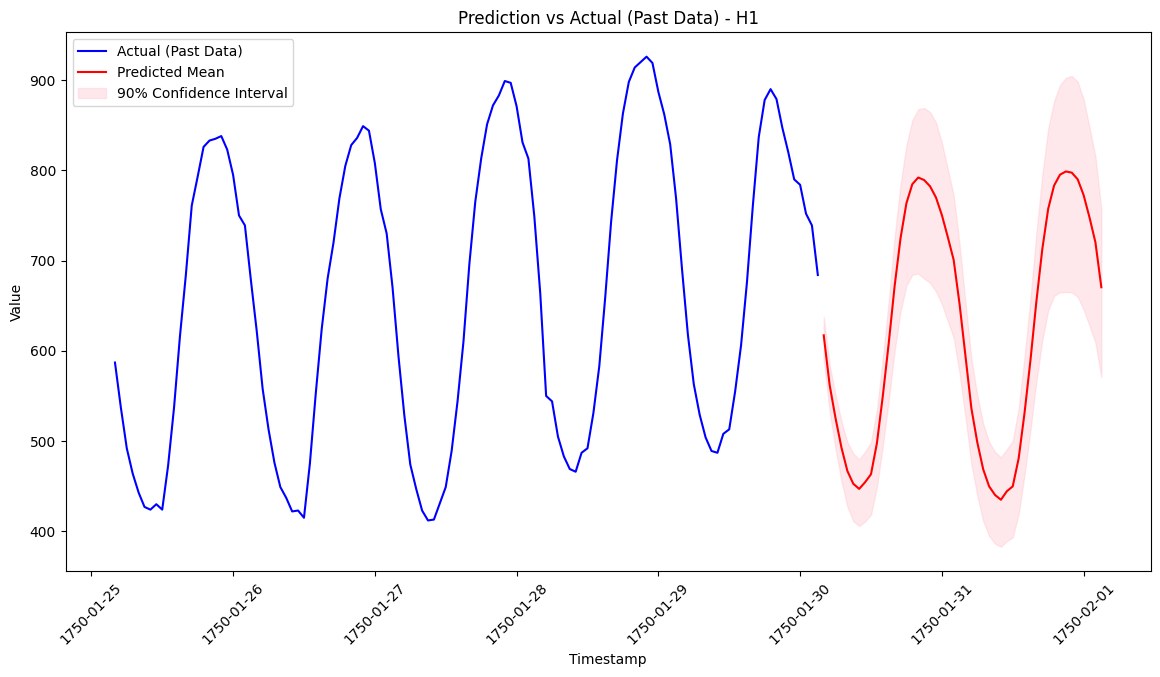

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# **ターゲットのアイテム**
target_item_id = "H1"  # データ確認後に適切な ID に変更

# **過去の実測データを `item_id` でフィルタ**
df_actual = df_last120.xs(target_item_id, level="item_id")

# **予測データを取得**
df_pred = predictions.xs(target_item_id, level="item_id")

# **インデックスを `datetime` に変換**
df_actual.index = pd.to_datetime(df_actual.index)
df_pred.index = pd.to_datetime(df_pred.index)

# **グラフ描画**
plt.figure(figsize=(14, 7))

# **過去の実測データをプロット**
plt.plot(df_actual.index, df_actual["target"], label="Actual (Past Data)", color="blue")

# **予測データの平均値をプロット**
plt.plot(df_pred.index, df_pred["mean"], label="Predicted Mean", color="red")

# **予測の信頼区間（90% CI）を塗りつぶし**
plt.fill_between(df_pred.index, df_pred["0.1"], df_pred["0.9"], color="lightpink", alpha=0.3, label="90% Confidence Interval")

# **ラベル設定**
plt.title(f"Prediction vs Actual (Past Data) - {target_item_id}")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)

# **グラフ表示**
plt.show()


In [25]:
# CSVファイルの保存先
output_csv_path = "/content/predictions_H1.csv"

# 予測データを DataFrame に変換
predictions_reset = predictions.reset_index()

# H1 のデータのみ抽出
predictions_H1 = predictions_reset[predictions_reset["item_id"] == "H1"]

# CSVファイルとして保存（Windows対応の UTF-8-BOM でエンコード）
predictions_H1.to_csv(output_csv_path, index=False, encoding="utf-8-sig")

print(f"H1 の予測データを保存しました: {output_csv_path}")


H1 の予測データを保存しました: /content/predictions_H1.csv
